<a href="https://colab.research.google.com/github/NoManNayeem/Machine-Learning-Data-Science/blob/main/Gradient_Boosting%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/hepml/master?urlpath=lab/tree/notebooks%2Flesson04_intro-to-gradient-boosting.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson04_intro-to-gradient-boosting.ipynb)

## Learning objectives
* Understand the conceptual difference between bagging and boosting ensembles
* Understand how gradient boosting works for regression tasks
* Learn how to tune the key hyperparameters of gradient boosting ensembles

## What is gradient boosting?
Boosting refers to an ensemble technique that combines multiple simple or "weak" models into a single composite model. Unlike the bagging method we saw in previous lessons, boosting methods train the models _sequentially_, where each model is chosen to improve the overall performance. 

<div style="text-align: center">
<img src='https://github.com/lewtun/hepml/blob/master/notebooks/images/bagging_vs_boosting.png?raw=1'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://www.quora.com/Whats-the-difference-between-boosting-and-bagging </p>
</div>

In gradient boosting, the trick is to fit each new model to the _residual errors_ made by the previous one, e.g. the algorithm runs as follows:

1. Fit a crappy model to the data $F_1(X) = y$
2. Fit a crappy model to the residuals $h_1(X) = y - F_1(X)$
3. Create a composite model $F_2(X) = F_1(X) + h_1(X)$
4. Repeat steps 2 and 3 recursively $F_{m+1}(X) = F_m(X) + h_m(X)$ for $M$ steps until $F_M(X)$ is good enough. Note that our task at each step is to train the model $h_m(X) = y - F_m(X)$ on the residual errors.

For sufficiently large $M$, the result is a strong composite model $F_M(X) = \hat{y}$ that estimates the target values $y$.

> Note: although $h_m$ can be any model you want, in practice most boosting algorithms are based on tree regressors.

The "gradient" part of gradient boosting is related to the fact that the loss function we wish to optimise is generically given by

$$ L(y, F_M(X)) = \frac{1}{N}\sum_{i=1}^N L(y_i, F_M(x_i)) $$

and for regression tasks it turns out that training models on the residual errors is equivalent to optimising the Mean Squared Error (MSE):

$$ L(y, F_M(X)) = \frac{1}{N}\sum_{i=1}^N \left(y_i - F_M(x_i) \right)^2 $$

In particular, for each $m\in 1, \ldots, M$ we calculate the gradient

$$ r_{im} = - \left[ \frac{\partial L(y_i, F(x_i)}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)} \,, \qquad i = 1, \ldots , N$$

and fit a weak learner to these gradient components. The update step with gradient descent then looks like

$$ F_{m+1}(X) = F_m(X) + \gamma_m h_m(X)$$

where $\gamma_m$ is the learning rate or "shrinkage" parameter that controls the contribution of each tree (or how "far" a step we take in the direction of the average gradient).

In this lesson we look at the basic mechanics behind gradient boosting for _regression_ tasks. The classification case is conceptually the same, but involves a different loss function and some technical details on how to combine predictions to build the ensemble.

## Import libraries

In [ ]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [ ]:
# uncomment this if running locally or on Google Colab
# !pip install --upgrade hepml

In [ ]:
# data wrangling
import pandas as pd
import numpy as np

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
# from hepml.core import plot_regression_tree

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Generate the data
To keep things simple in this lesson, we will generate a noisy quadratic training set that has just a single feature per example, along with a continuous target:

In [ ]:
number_of_examples = 10000000
# fix the seed for reproducibility
np.random.seed(42)
# generate features
X = np.random.rand(number_of_examples, 1) - 0.5
# generate target
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(number_of_examples)
# create pandas.DataFrame
data = pd.DataFrame(data=np.stack([X[:, 0], y], axis=1), columns=["X", "y"])
data.head()

,X,y
0,-0.125460,0.037930
1,0.450714,0.643146
2,0.231994,0.179291
3,0.098658,0.054528
4,-0.343981,0.338932


Next, let's visualise our training set:

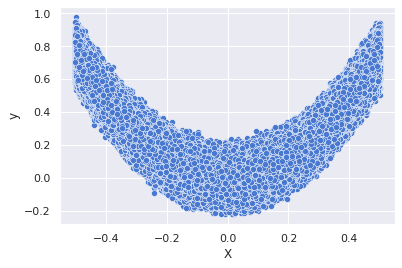

In [ ]:
sns.scatterplot(x="X", y="y", data=data)
plt.show()

## Step 1 - build a model on the data

To create a boosted regression model, we start by creating a crappy model that predicts the initial approximation of $y$. As discussed above it is common to use shallow Decision Trees, so let's fix the `max_depth` to a small number:

In [ ]:
tree_1 = DecisionTreeRegressor(max_depth=2)
tree_1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

The resulting tree can be visualised with a helper function from our `hepml` library:

In [ ]:
# plot_regression_tree(tree_1, data.columns, fontsize=24)

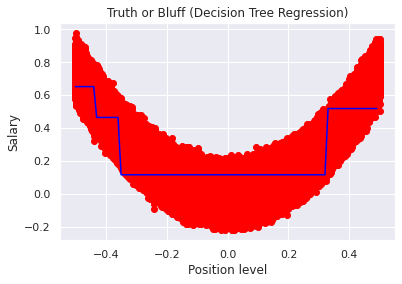

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))

plt.scatter(X, y, color = 'red')
plt.plot(X_grid, tree_1.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Decision Tree Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)



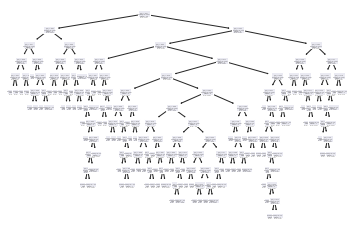

In [ ]:
tree.plot_tree(clf)
plt.show()

Note that this tree looks similar to the classification trees we have analysed in previous lessons. The main difference is that instead of predicting a discrete class like "signal" or "background" in each leaf node, a regression tree predicts a continuous _value_. This value is simply the average target value of the training examples associated with a given node. 

The CART algorithm is also similar to classification, except we now split the training set to minimise the Mean Squared Error (MSE) instead og Gini impurity:

$$J(k, t_k) = \frac{m_\mathrm{left}}{m}\mathrm{MSE}_\mathrm{left} + \frac{m_\mathrm{right}}{m}\mathrm{MSE}_\mathrm{right} $$

where 

$$ \mathrm{MSE}_\mathrm{node} = \sum_{i\in \mathrm{node}} \left(\hat{y}_\mathrm{node} - y^{(i)}\right)^2 
\qquad \mathrm{and} \qquad
\hat{y}_\mathrm{node} = \frac{1}{m_\mathrm{node}} \sum_{i\in \mathrm{node}} y^{(i)}
$$

Next, let's add a new column of predictions to our `pandas.DataFrame`

In [ ]:
data["Tree 1 prediction"] = tree_1.predict(X)
data.head()

,X,y,Tree 1 prediction
0,-0.125460,0.051573,0.123566
1,0.450714,0.594480,0.528568
2,0.231994,0.166052,0.123566
3,0.098658,-0.070178,0.123566
4,-0.343981,0.343986,0.123566


and visualise the quality of the predictions on the training set:

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    plt.ylabel("$y$", fontsize=16)
    plt.xlabel("$X$", fontsize=16)

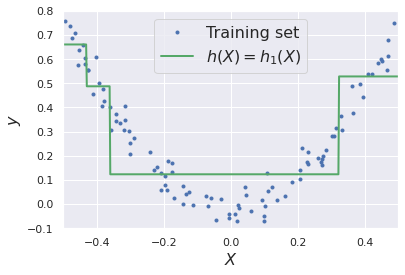

In [ ]:
plot_predictions(
    [tree_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(X)=h_1(X)$", style="g-", data_label="Training set"
)
plt.show()

## Step 2 - build a model on the residuals

Unsurprisingly, the weak model above is barely able to capture the structure of the data (i.e. it has high bias). However, we can improve the predictions by training a second regression tree on the _residual errors_ made by the first tree:

In [ ]:
data["Tree 1 residual"] = data["y"] - data["Tree 1 prediction"]
data.head()

,X,y,Tree 1 prediction,Tree 1 residual
0,-0.125460,0.051573,0.123566,-0.071993
1,0.450714,0.594480,0.528568,0.065911
2,0.231994,0.166052,0.123566,0.042485
3,0.098658,-0.070178,0.123566,-0.193744
4,-0.343981,0.343986,0.123566,0.220420


In [ ]:
tree_2 = DecisionTreeRegressor(max_depth=2)
tree_2.fit(X, data["Tree 1 residual"])

DecisionTreeRegressor(max_depth=2)

## Step 3 - create a composite model

Now we have an ensemble consisting of two trees. We can get the predictions from the ensemble by simply summing the predictions across all trees:

In [ ]:
data["Tree 2 prediction"] = tree_2.predict(X)
data["Tree 1 + tree 2 prediction"] = sum(tree.predict(X) for tree in (tree_1, tree_2))
data.head()

,X,y,Tree 1 prediction,Tree 1 residual,Tree 2 prediction,Tree 1 + tree 2 prediction
0,-0.125460,0.051573,0.123566,-0.071993,-0.090398,0.033168
1,0.450714,0.594480,0.528568,0.065911,0.039913,0.568481
2,0.231994,0.166052,0.123566,0.042485,0.039913,0.163479
3,0.098658,-0.070178,0.123566,-0.193744,-0.090398,0.033168
4,-0.343981,0.343986,0.123566,0.220420,0.159838,0.283404


As before, we can plot the predictions of both our second tree on the residuals, along with the predictions from the ensemble on the training set:

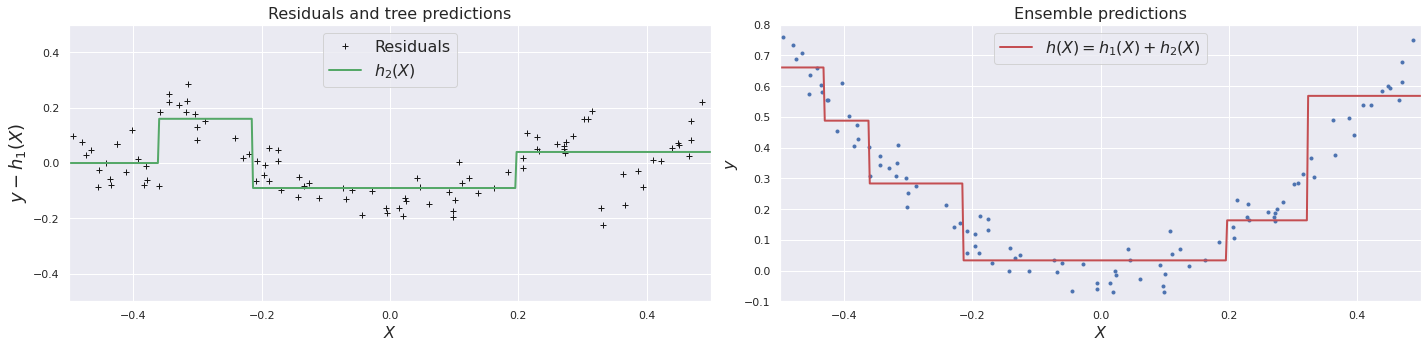

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))

plt.subplot(ax0)
plot_predictions(
    [tree_2],
    X,
    data["Tree 1 residual"],
    axes=[-0.5, 0.5, -0.5, 0.5],
    label="$h_2(X)$",
    style="g-",
    data_style="k+",
    data_label="Residuals",
)
plt.ylabel("$y - h_1(X)$", fontsize=18)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(ax1)
plot_predictions([tree_1, tree_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(X) = h_1(X) + h_2(X)$")
plt.title("Ensemble predictions", fontsize=16)
plt.tight_layout()

From the figure, we see that the ensemble's predictions have improved compared to our first crappy model!

## Step 4 - rinse and repeat

It is not hard to see how we can continue this procedure by successively adding new models:

$$ F_{m+1}(x) = F_m(x) + h_m(x)\,, \qquad \mathrm{for} \, m \geq 0 $$

In [ ]:
data["Tree 1 + tree 2 residual"] = data["Tree 1 residual"] - data["Tree 2 prediction"]
data.head()

,X,y,Tree 1 prediction,Tree 1 residual,Tree 2 prediction,Tree 1 + tree 2 prediction,Tree 1 + tree 2 residual
0,-0.125460,0.051573,0.123566,-0.071993,-0.090398,0.033168,0.018405
1,0.450714,0.594480,0.528568,0.065911,0.039913,0.568481,0.025998
2,0.231994,0.166052,0.123566,0.042485,0.039913,0.163479,0.002573
3,0.098658,-0.070178,0.123566,-0.193744,-0.090398,0.033168,-0.103346
4,-0.343981,0.343986,0.123566,0.220420,0.159838,0.283404,0.060582


In [ ]:
tree_3 = DecisionTreeRegressor(max_depth=2)
tree_3.fit(X, data["Tree 1 + tree 2 residual"])

DecisionTreeRegressor(max_depth=2)

In [ ]:
data["Tree 3 prediction"] = tree_3.predict(X)
data["Tree 1 + tree 2 + tree 3 prediction"] = sum(tree.predict(X) for tree in (tree_1, tree_2, tree_3))
data["Final residual"] = data["Tree 1 + tree 2 residual"] - data["Tree 3 prediction"]
data.head()

,X,y,Tree 1 prediction,Tree 1 residual,Tree 2 prediction,Tree 1 + tree 2 prediction,Tree 1 + tree 2 residual,Tree 3 prediction,Tree 1 + tree 2 + tree 3 prediction,Final residual
0,-0.125460,0.051573,0.123566,-0.071993,-0.090398,0.033168,0.018405,0.007043,0.040212,0.011361
1,0.450714,0.594480,0.528568,0.065911,0.039913,0.568481,0.025998,-0.068529,0.499952,0.094528
2,0.231994,0.166052,0.123566,0.042485,0.039913,0.163479,0.002573,0.007043,0.170523,-0.004471
3,0.098658,-0.070178,0.123566,-0.193744,-0.090398,0.033168,-0.103346,0.007043,0.040212,-0.110390
4,-0.343981,0.343986,0.123566,0.220420,0.159838,0.283404,0.060582,0.007043,0.290448,0.053538


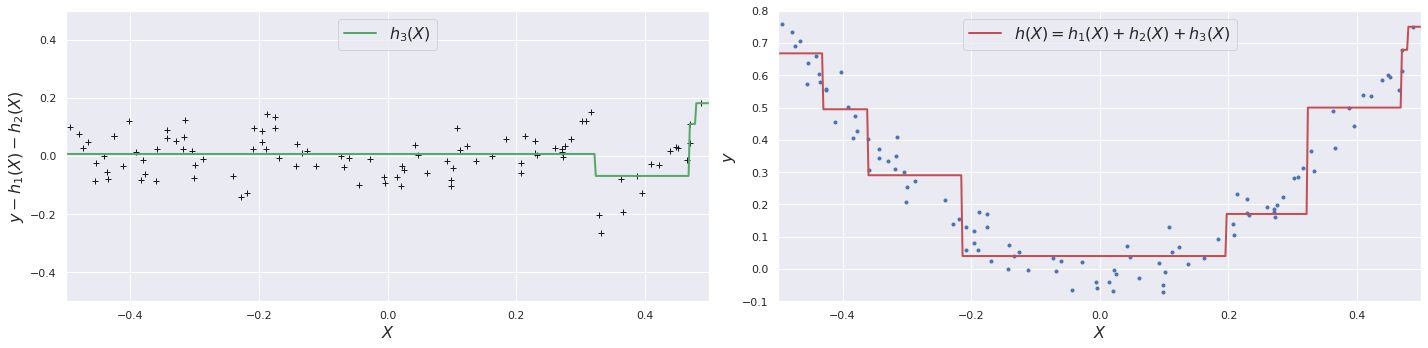

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))

plt.subplot(ax0)
plot_predictions(
    [tree_3],
    X,
    data["Tree 1 + tree 2 residual"],
    axes=[-0.5, 0.5, -0.5, 0.5],
    label="$h_3(X)$",
    style="g-",
    data_style="k+",
)
plt.ylabel("$y - h_1(X) - h_2(X)$", fontsize=16)

plt.subplot(ax1)
plot_predictions(
    [tree_1, tree_2, tree_3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(X) = h_1(X) + h_2(X) + h_3(X)$",
)
plt.tight_layout()

As promised, adding more models to the ensemble improves the predictions (at least qualitatively)!

## Gradient boosting with scikit-learn

Manually building up the gradient boosting ensemble is a drag, so in practice it is better to make use of scikit-learn's [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) class. Similar to the Random Forest classes that we've worked with in previous lessons, it has similar hyperparameters like `max_depth` and `min_samples_leaf` that control the growth of each tree, along with parameters like `n_estimators` which control the size of the ensemble. For example, we can reconstruct our hand-crafted ensemble from before as follows:

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

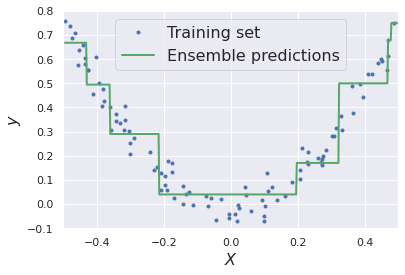

In [ ]:
plot_predictions(
    [gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions", style="g-", data_label="Training set"
)
plt.show()

## Choosing hyperparameters

There are two main hyperparameters that you need to tune to prevent a boosted regression ensemble from overfitting the training set:

* `learning_rate`: this hyperparameter weights the contribution of each tree. Low values like 0.1 imply more trees are needed in the ensemble, but will typically lead to better generalisation error.
* `n_estimators`: this hyperparameter controls the number of trees in the ensemble. Adding too many trees can lead to overfitting.

### Effect of learning rate

To show the effect of the learning rate, let's train two ensembles at different extremes:

In [ ]:
gbrt_high_lr = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt_high_lr.fit(X, y)

gbrt_low_lr = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_low_lr.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

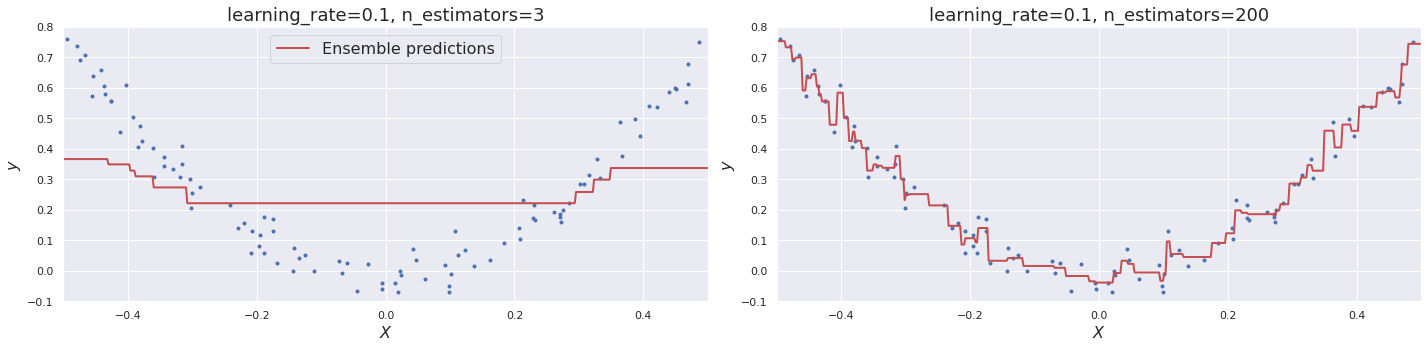

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))

plt.subplot(ax0)
plot_predictions([gbrt_high_lr], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title(f"learning_rate={gbrt_high_lr.learning_rate}, n_estimators={gbrt_high_lr.n_estimators}", fontsize=18)

plt.subplot(ax1)
plot_predictions([gbrt_low_lr], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"learning_rate={gbrt_low_lr.learning_rate}, n_estimators={gbrt_low_lr.n_estimators}", fontsize=18)

plt.tight_layout()

### Early stopping

In practice the learning rate and number of trees in the ensemble are found via cross-validation. However, it has been observed empircally that small learning rates like 0.1 produce models that generalise better. For fixed learing rate, we can find the optimal number of trees using a technique known as "early stoppping". Here the idea is to use a validation set to measure how the error decreases as we add more trees and find the optimal point from the curve:

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_valid, y_pred) for y_pred in gbrt.staged_predict(X_valid)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

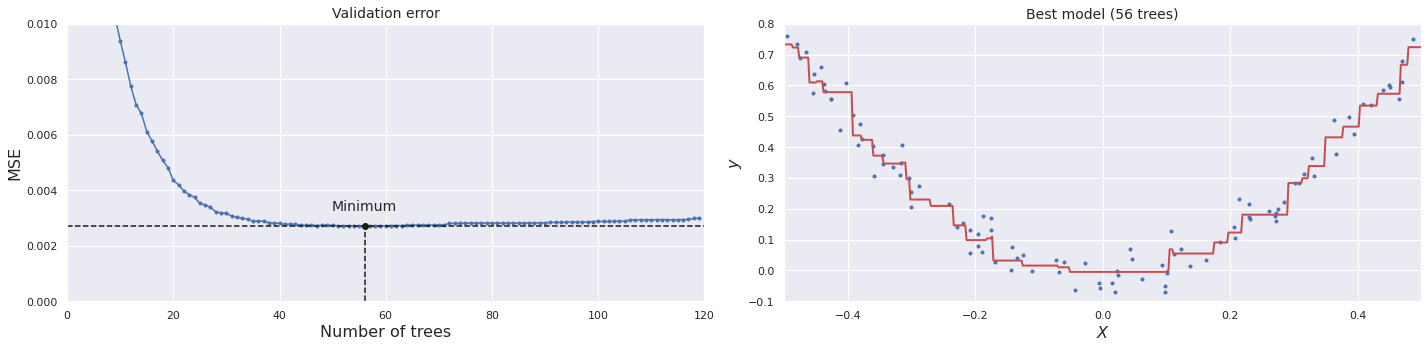

In [ ]:
min_error = np.min(errors)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))

plt.subplot(ax0)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error * 1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(ax1)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"Best model ({bst_n_estimators} trees)", fontsize=14)

plt.tight_layout()

In practice it is better to actually stop the training when the early stopping criterion is met, instead of training many redundant models. In scikit-learn, this is configured by setting `warm_start=True` which allows for incremental training and can be use to stop the training loop when some threshold is met, e.g.

In [ ]:
gbrt = GradientBoostingRegressor(
    n_estimators=120, validation_fraction=0.2, n_iter_no_change=5, tol=1e-5, max_depth=2, random_state=42, warm_start=True
)
gbrt.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=120, n_iter_no_change=5,
                          random_state=42, tol=1e-05, validation_fraction=0.2,
                          warm_start=True)

Optimal number of trees: 60
Minimum validation MSE: 0.0008984023296480315


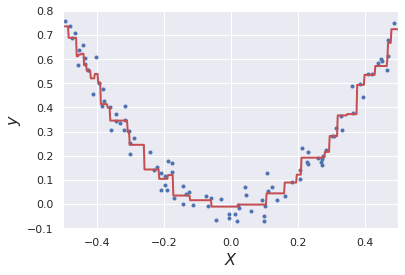

In [ ]:
print(f"Optimal number of trees: {gbrt.n_estimators_}")
print(f"Minimum validation MSE: {np.min(gbrt.train_score_)}")

plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8])

Using scikit-learn's [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradientboostingclassifier) to explore how the algorithm's hyperparameters influence the [decision boundary](https://en.wikipedia.org/wiki/Decision_boundary) on the following synthetic dataset for binary classification:

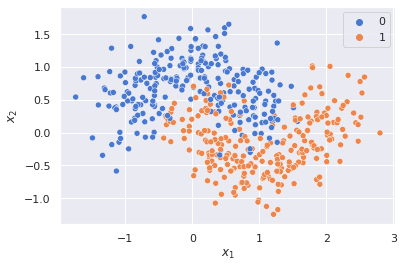

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()